# Main Calculation

The `crystal17.main` plugin is the core calculation plugin.
It is designed with a more programmatic
input interface , to create the input ``.d12`` and ``.gui`` files,
from a set of AiiDA :py:class:`~aiida.orm.nodes.data.Data` nodes.

.. seealso::

    See :ref:`main_calculation_immigrant` for a method
    to immigrate existing output/input files as a
    ``crystal17.main`` calculation.

## Initial Setup

To run a computation, first ensure AiiDA is running:

In [3]:
!verdi status

 ✓ profile:     On profile test_crystal17
 ✓ repository:  /Users/cjs14/GitHub/aiida-cjs-working/databases/aiida/.aiida/repository/test_crystal17
 ✓ postgres:    Connected as cjs14@localhost:5432
 ✓ rabbitmq:    Connected to amqp://127.0.0.1?heartbeat=600
 ✓ daemon:      Daemon is running as PID 35477 since 2019-07-18 12:57:21


.. seealso::

    AiiDA documentation: :ref:`aiida:quick_installation`

If `aiida-crystal17` is installed,
the `crystal17.main` computation should be available:

In [4]:
!verdi plugin list aiida.calculations crystal17.main

Inputs
      basissets:  required  BasisSetData        Use a node for the basis set of one of the elements in the structure. You h ...
           code:  required  Code                The Code to use for this job.
     parameters:  required  CryInputParamsData  the input parameters to create the .d12 file content.
      structure:  required  StructureData       structure used to construct the input fort.34 (gui) file
          kinds:  optional  KindData            additional structure kind specific data (e.g. initial spin)
       metadata:  optional                      
       symmetry:  optional  SymmetryData        the symmetry of the structure, used to construct the input .gui file (fort. ...
      wf_folder:  optional  RemoteData          An optional working directory, of a previously completed calculation, conta ...
Outputs
  remote_folder:  required  RemoteData          Input files necessary to run the process will be stored in this folder node ...
        results:  required  Dic

To use the python interface,
first ensure a profile is loaded in the python kernel,
and import the required modules:

In [1]:
from aiida import load_profile
profile = load_profile()
profile.name

'test_crystal17'

In [2]:
import os
from six import StringIO
from aiida.orm import Code
from aiida.plugins import (
    DataFactory, WorkflowFactory, CalculationFactory)
from aiida.engine import run_get_node
from aiida_crystal17.common import display_json
from aiida_crystal17.tests import read_resource_text, resource_context
from aiida.tools.visualization import Graph
from jsonextended import edict

## Input Node Creation

.. seealso::
    
    [CRYSTAL17 Manual](http://www.crystal.unito.it/Manuals/crystal17.pdf)

### Code

.. seealso::

    AiiDA documentation: :ref:`aiida:setup_code`

An :py:class:`~aiida.orm.nodes.data.code.Code` node should be set up in advance,
to use the `crystal17.basic` calculation plugin,
and call the ``runcry17`` executable
(or ``mock_runcry17`` used here for test purposes).

In [7]:
from aiida_crystal17.tests.utils import get_or_create_local_computer, get_or_create_code
computer = get_or_create_local_computer('work_directory', 'localhost')
code = get_or_create_code('crystal17.main', computer, 'mock_crystal17')
code.get_full_text_info()

[['PK', 23],
 ['UUID', '8451bd5e-397a-4014-9982-340b571a48c8'],
 ['Label', 'crystal17.main-mock_crystal17@localhost'],
 ['Description', ''],
 ['Default plugin', 'crystal17.main'],
 ['Type', 'remote'],
 ['Remote machine', 'localhost'],
 ['Remote absolute path', '//anaconda/envs/aiida-workshop/bin/mock_crystal17'],
 ['Prepend text', 'No prepend text'],
 ['Append text', 'No append text']]

### Input Parameters (Geometry Independent)

The :py:class:`~aiida_crystal17.data.input_params.CryInputParamsData`
supplies (geometry independent) data required to create the `input.d12` file.

In [8]:
param_dict = {"scf":{"k_points": (8, 8)}}
params = DataFactory('crystal17.parameters')(data=param_dict)
params

<CryInputParamsData: uuid: 552ca25b-109f-4c25-8513-b441ba1b5d7c (unstored)>

The input data is validated against the :ref:`cry_main_input_schema`,
which can also be obtained from the `data_schema` attribute.

.. note::

    The only mandated key is ``scf.k_points`` (known as ``SHRINK`` in CRYSTAL17)

In [9]:
param_cls = DataFactory('crystal17.parameters')
edict.pprint(params.data_schema, keycolor="blue")

$schema:     http://json-schema.org/draft-04/schema#
additionalProperties: False
description: Allowed Inputs For CRYSTAL17 .d12 file
properties:
  basis_set:
    additionalProperties: False
    description: Basis sets input and control
    properties:  {...}
    title:       Block 2
    type:        object
  geometry:
    additionalProperties: False
    description: Geometry input, manipulation and optimisation control
    properties:  {...}
    title:       Block 1
    type:        object
  scf:
    additionalProperties: False
    dependencies: {...}
    description: Single particle Hamiltonian and SCF control
    properties:  {...}
    required:    [k_points]
    title:       Block 3
    type:        object
  title:
    description: the title of the run
    type: string
required:    [scf]
title:       CRYSTAL17 Input
type:        object


In [10]:
params = DataFactory('crystal17.parameters')(data={"scf": {}})

ValidationError: - 'k_points' is a required property [key path: 'scf']

It is also possible to reverse engineer the input data,
from an existing input file, using
:py:class:`~aiida_crystal17.parsers.raw.inputd12_read.extract_data`,
which is also exposed on the command line as `verdi data crystal17.parse stdin`. 

In [11]:
from aiida_crystal17.parsers.raw.inputd12_read import extract_data
param_dict, basis_sets, atom_props = extract_data("""\
MgO bulk
EXTERNAL
OPTGEOM
FULLOPTG
END
END
12 3
1 0 3  2.  0.
1 1 3  8.  0.
1 1 3  2.  0.
8 2
1 0 3  2.  0.
1 1 3  6.  0.
99   0
END
DFT
B3LYP
SPIN
END
SHRINK
8 8
ANDERSON
SMEAR
0.1
ATOMSPIN
2
1 1 2 -1
PPAN
END
""")
param_dict

{'title': 'MgO bulk',
 'geometry': {'optimise': {'type': 'FULLOPTG'}},
 'scf': {'dft': {'xc': 'B3LYP', 'SPIN': True},
  'k_points': (8, 8),
  'fock_mixing': 'ANDERSON',
  'numerical': {'SMEAR': 0.1},
  'post_scf': ['PPAN']}}

In [12]:
from aiida_crystal17.parsers.raw.inputd12_write import write_input
print(write_input(param_dict, basis_sets, atom_props))

MgO bulk
EXTERNAL
OPTGEOM
FULLOPTG
ENDOPT
END
12 3
1 0 3  2.  0.
1 1 3  8.  0.
1 1 3  2.  0.
8 2
1 0 3  2.  0.
1 1 3  6.  0.
99 0
END
DFT
B3LYP
SPIN
END
SHRINK
8 8
ATOMSPIN
2
1 1
2 -1
SMEAR
0.1
ANDERSON
PPAN
END



### Atomic Structure

The ``structure`` refers to a standard
:py:class:`~aiida.StructureData` node, and is used to create the `main.gui`.

Structures consist of:

- A cell with a basis vectors and whether it is periodic, for each dimension
- ``Site`` with a cartesian coordinate and reference to a kind
- ``Kind`` which details the species and composition at one or more sites

The simplest way to create a structure is *via* :py:mod:`ase`:

In [13]:
from ase.spacegroup import crystal
atoms = crystal(
    symbols=[12, 8],
    basis=[[0, 0, 0], [0.5, 0.5, 0.5]],
    spacegroup=225,
    cellpar=[4.21, 4.21, 4.21, 90, 90, 90])
struct_cls = DataFactory('structure')
structure = struct_cls(ase=atoms)
structure

<StructureData: uuid: 45ad9994-71b4-4ec3-8308-5f2bdb94f666 (unstored)>

These structures can be visualised using standard ASE methods.

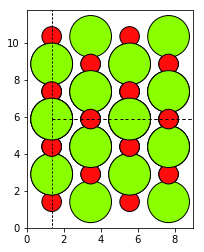

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
atoms = structure.get_ase()
fig, ax = plt.subplots()
plot_atoms(atoms.repeat((2,2,2)), 
           ax, radii=0.8, show_unit_cell=True, 
           rotation=('45x,0y,0z'));

As default, one kind is created per atomic species
(named as the atomic symbol):

In [15]:
structure.get_site_kindnames()

['Mg', 'Mg', 'Mg', 'Mg', 'O1', 'O1', 'O1', 'O1']

However, we may want to specify more than one kind per species
(for example to setup anti-ferromagnetic spin).
We can achieve this by tagging the atoms:

In [16]:
atoms_afm = atoms.copy()
atoms_afm.set_tags([1, 1, 2, 2, 0, 0, 0, 0])
structure_afm = struct_cls(ase=atoms_afm)
structure_afm.get_site_kindnames()

['Mg1', 'Mg1', 'Mg2', 'Mg2', 'O', 'O', 'O', 'O']

.. note::

    Since we **always** use the ``EXTERNAL`` keyword for geometry,
    any manipulation to the geometry is undertaken before calling CRYSTAL
    (i.e. we delegate the responsibility for geometry away from CRYSTAL).

### Kind Specific Parameters

Also, we may want to add atom specific inputs to the ``.d12``,
such as initial spin and frozen atoms (for optimisation).

In [18]:
kind_cls = DataFactory("crystal17.kinds")
kind_data = kind_cls(data={
    "kind_names": ["Mg1", "Mg2", "O"],
    "spin_alpha": [True, False, False],
    "spin_beta": [False, True, False],
    "fixed": [False, False, True],
    "ghosts": [False, False, False]
})
display_json(kind_data.kind_dict)

```json
{
  "Mg1": {
    "spin_alpha": true,
    "spin_beta": false,
    "fixed": false,
    "ghosts": false
  },
  "Mg2": {
    "spin_alpha": false,
    "spin_beta": true,
    "fixed": false,
    "ghosts": false
  },
  "O": {
    "spin_alpha": false,
    "spin_beta": false,
    "fixed": true,
    "ghosts": false
  }
}
```

In [19]:
from aiida_crystal17.parsers.raw.inputd12_write import create_atom_properties
atom_props2 = create_atom_properties(structure_afm, kind_data)
atom_props2

{'spin_alpha': [1, 2],
 'spin_beta': [3, 4],
 'unfixed': [1, 2, 3, 4],
 'ghosts': []}

In [20]:
print(write_input(param_dict, basis_sets, atom_props2))

MgO bulk
EXTERNAL
OPTGEOM
FULLOPTG
FRAGMENT
4
1 2 3 4
ENDOPT
END
12 3
1 0 3  2.  0.
1 1 3  8.  0.
1 1 3  2.  0.
8 2
1 0 3  2.  0.
1 1 3  6.  0.
99 0
END
DFT
B3LYP
SPIN
END
SHRINK
8 8
ATOMSPIN
4
1 1
2 1
3 -1
4 -1
SMEAR
0.1
ANDERSON
PPAN
END



### Basis Sets

Basis sets are stored as separate
:py:class:`~aiida_crystal17.data.basis_set.BasisSetData` nodes,
in a similar fashion to :py:class:`~aiida.orm.nodes.data.upf.UpfData`.
They are created individually from a text file,
which contains the content of the basis set
and (optionally) a YAML style header section, fenced by ``---``:

In [21]:
mg_basis_content = read_resource_text('basis_sets', 'sto3g', 'sto3g_Mg.basis')
print(mg_basis_content)

---
author: John Smith
year: 1999
class: sto3g
---
12 3
1 0 3  2.  0.
1 1 3  8.  0.
1 1 3  2.  0.


The attributes of the basis set are stored in the database,
and the md5 hash-sum is used to test equivalence of two basis sets.

In [22]:
basis_cls = DataFactory('crystal17.basisset')
mg_basis, created = basis_cls.get_or_create(StringIO(mg_basis_content))
display_json(mg_basis.attributes)
mg_basis.content

```json
{
  "md5": "0731ecc3339d2b8736e61add113d0c6f",
  "year": 1999,
  "class": "sto3g",
  "author": "John Smith",
  "element": "Mg",
  "filename": "sto3g_Mg.basis",
  "basis_type": "all-electron",
  "num_shells": 3,
  "atomic_number": 12
}
```

'12 3\n1 0 3  2.  0.\n1 1 3  8.  0.\n1 1 3  2.  0.'

A simpler way to create and refer to basis sets, is *via* a **family group**.
All basis sets in a folder can be read and saved to a named family by:

In [23]:
with resource_context('basis_sets', 'sto3g') as path:
   nfiles, nuploaded = basis_cls.upload_basisset_family(
                           path,
                           "sto3g", "group of sto3g basis sets",
                           extension=".basis", stop_if_existing=False)
basis_cls.get_basis_group_map("sto3g")

{'Mg': <BasisSetData: uuid: 832e1641-6c54-49c6-9039-42416fe8df66 (pk: 24)>,
 'Ni': <BasisSetData: uuid: f9138f14-401b-4287-800e-8e6e4a95f0d6 (pk: 25)>,
 'O': <BasisSetData: uuid: 3ab50757-05b6-48de-bd8e-6488472c3c69 (pk: 26)>}

or at the command line:

In [24]:
!verdi data crystal17.basis uploadfamily --help

Usage: verdi data crystal17.basis uploadfamily [OPTIONS]

  Upload a family of CRYSTAL Basis Set files.

Options:
  --path PATH                    Path to a folder containing the Basis Set
                                 files
  --ext TEXT                     the file extension to filter by
  --name TEXT                    Name of the BasisSet family  [required]
  -D, --description DESCRIPTION  A description for the family
  --stop-if-existing             Abort when encountering a previously uploaded
                                 Basis Set file
  --dry-run                      do not commit to database or modify
                                 configuration files
  -h, --help                     Show this message and exit.


In [25]:
!verdi data crystal17.basis listfamilies

Family      Num Basis Sets
--------  ----------------
sto3g                    3



Basis families can be searched by the elements they contain:

In [26]:
basis_cls.get_basis_groups(["Ni", "O"])

[<Group: "sto3g" [type crystal17.basisset], of user chrisj_sewell@hotmail.com>]

Basis sets can also be extracted for a particular structure.

In [27]:
basis_cls.get_basissets_from_structure(structure, "sto3g")

{'Mg': <BasisSetData: uuid: 832e1641-6c54-49c6-9039-42416fe8df66 (pk: 24)>,
 'O': <BasisSetData: uuid: 3ab50757-05b6-48de-bd8e-6488472c3c69 (pk: 26)>}

.. important::

    Unlike `aiida-quantumespresso.pw`,
    ``crystal17.main`` uses one basis sets per atomic number only **NOT** per kind.
    This is because, using multiple basis sets per atomic number is rarely used in CRYSTAL17,
    and is limited anyway to only two types per atomic number.

### Symmetry

In the ``main.gui`` file,
as well as using the dimensionality (i.e. periodic boundary conditions),
basis vectors and atomic positions, provided by the ``structure``,
we also need to specify the atomic symmetry of the structure.

:py:class:`~aiida_crystal17.data.symmetry.SymmetryData` is used to store this data, as a validated dictionary.

.. note::

    The ``operations`` are given as a flattened version of the rotation matrix,
    followed by the translation vector.

In [28]:
symmetry_cls = DataFactory("crystal17.symmetry")
edict.pprint(symmetry_cls.data_schema, keycolor="blue")

$schema:     http://json-schema.org/draft-07/schema
additionalProperties: True
properties:
  basis:
    description: whether the symmetry operations are fractional or cartesian
    enum: [fractional, cartesian]
    type: string
  computation:
    description: details of the computation
    type: object
  equivalent_sites:
    description: mapping table to equivalent atomic sites
    items: {...}
    type: array
  hall_number:
    description: Hall number defining the symmetry group
    maximum: 530
    minimum: 1
    type: [null, integer]
  operations:
    description: symmetry operations, should at least include the unity
                 operation
    items: {...}
    minItems: 1
    type: array
    uniqueItems: True
required:    [hall_number, operations, basis]
title:       structure symmetry settings
type:        object


The simplest symmetry would be the unitary operator.

In [29]:
symmetry = symmetry_cls(data={
    "hall_number": 1,
    "basis": "fractional",
    "operations": [
        [1,0,0,0,1,0,0,0,1,0,0,0]
    ]
})
symmetry.attributes

{'hall_number': 1, 'basis': 'fractional', 'num_symops': 1}

The full symmetry operations of a periodic structure, 
can be computed using the `crystal17.sym3d` workflow.
This uses the `spglib <https://atztogo.github.io/spglib/>`_ library
to compute symmetries, but with the added constraint that sites
with the same ``Kind`` must be symmetrically equivalent.

In [30]:
!verdi plugin list aiida.workflows crystal17.sym3d

Inputs
   settings:  required  Dict           
        cif:  optional  CifData        
   metadata:  optional                 
  structure:  optional  StructureData  
Outputs
   symmetry:  required  SymmetryData   
  structure:  optional  StructureData  
Exit codes
          1:  The process has failed with an unspecified error.
          2:  The process failed with legacy failure mode.
         10:  The process returned an invalid output.
         11:  The process did not register a required output.
        300:  One of either a structure or cif input must be supplied
        301:  The supplied structure must be 3d (i.e. have all dimensions pbc=true)"
        302:  Idealize can only be used when standardize=true
        303:  The kind names supplied are not compatible with the structure
        304:  Error creating new structure
        305:  Error computing symmetry operations


In [31]:
sym3d_cls = WorkflowFactory("crystal17.sym3d")
builder = sym3d_cls.get_builder()
builder.settings = {"symprec": 0.01}
builder.structure = structure
sym_result = run_get_node(builder)

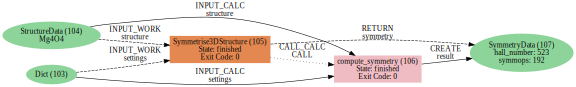

In [32]:
graph = Graph(graph_attr={'size': "8,8!", "rankdir": "LR"})
graph.recurse_ancestors(sym_result.result["symmetry"],
                        annotate_links="both")
graph.graphviz

This workflow can also optionally compute the primitive
and/or standardised form of the structure,
before computing the symmetry of the new structure.

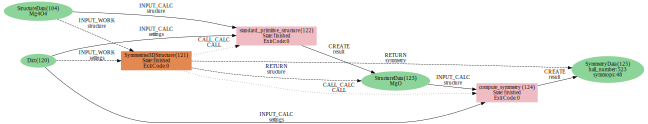

In [35]:
builder.settings = {
    "symprec": 0.01,
    "compute_primitive": True,
    "standardize_cell": True}
sym_result2 = run_get_node(builder)
graph = Graph(graph_attr={'size': "9,9!", "rankdir": "LR"})
graph.recurse_ancestors(sym_result2.result["structure"],
                        annotate_links="both")
graph.recurse_ancestors(sym_result2.result["symmetry"],
                        annotate_links="both")
graph.graphviz

The other option is to ``idealize`` the structure, which
removes distortions of the unit cell's atomic positions,
compared to the ideal symmetry.

## Setting Up and Running the Calculation

.. seealso::

    AiiDA documentation: :ref:`aiida:working_processes`

:py:class:`~aiida_crystal17.calculations.cry_main.CryMainCalculation`
provides a helper function to create, populate and validate the input builder.

In [49]:
from aiida_crystal17.tests import get_test_structure_and_symm
from aiida_crystal17.data.kinds import KindData

calc_cls = CalculationFactory('crystal17.main')
structure, symmetry  = get_test_structure_and_symm("NiO_afm")
kind_data = KindData(data={
    "kind_names": ["Ni1", "Ni2", "O"],
    "spin_alpha": [True, False, False], 
    "spin_beta": [False, True, False]})

calc_builder = calc_cls.create_builder(
    parameters={
        "title": "NiO Bulk with AFM spin",
        "scf.single": "UHF",
        "scf.k_points": (8, 8),
        "scf.spinlock.SPINLOCK": (0, 15),
        "scf.numerical.FMIXING": 30,
        "scf.post_scf": ["PPAN"]
    },
    unflatten=True,
    structure=structure,
    symmetry=symmetry,
    kinds=kind_data,
    bases="sto3g",
    code=Code.objects.get(label="crystal17.basic-mock_crystal17@localhost"),
    metadata={"options": {"resources": {
        "num_machines": 1, "num_mpiprocs_per_machine": 1}}}
)
display_json(calc_builder)

```json
{
  "metadata": {
    "options": {
      "resources": {
        "num_machines": 1,
        "num_mpiprocs_per_machine": 1
      }
    }
  },
  "basissets": {
    "Ni": [
      "uuid: f9138f14-401b-4287-800e-8e6e4a95f0d6 (pk: 25)"
    ],
    "O": [
      "uuid: 3ab50757-05b6-48de-bd8e-6488472c3c69 (pk: 26)"
    ]
  },
  "parameters": [
    "uuid: 92bba44f-b3df-4e04-ad69-a6b411cf787b (unstored)"
  ],
  "structure": [
    "uuid: 8d626706-24f9-43b8-bbf3-9b01b851e591 (pk: 169)"
  ],
  "symmetry": [
    "uuid: 2b594d60-b846-4a6b-aeb1-b0894984d438 (pk: 171)"
  ],
  "kinds": [
    "uuid: ed253aa1-bac0-4da6-8d00-679cf23e7dae (unstored)"
  ],
  "code": [
    "Remote code 'crystal17.basic-mock_crystal17@localhost' on localhost,",
    "pk: 1, uuid: d9ae48df-22cf-4ee2-9d47-0e16f48c8b0a"
  ]
}
```

In order to run the computation,
the builder can be parsed to one of the AiiDA ``run`` (blocking execution) or ``submit`` (non-blocking execution) functions:

In [50]:
result, calcnode = run_get_node(calc_builder)

The process can be monitored on the command line:

In [51]:
!verdi process list -a -D desc -l 4

  PK  Created    Process label          Process State    Process status
----  ---------  ---------------------  ---------------  ----------------
 174  19s ago    CryMainCalculation     ⏹ Finished [0]
 170  22s ago    compute_symmetry       ⏹ Finished [0]
 168  23s ago    primitive_structure    ⏹ Finished [0]
 167  23s ago    Symmetrise3DStructure  ⏹ Finished [0]

Total results: 4

Info: last time an entry changed state: 5s ago (at 12:33:22 on 2019-07-18)


Once the calculation is complete, a ``CalcJobNode`` will be created,
to store the settings and outcome of the computation.
Crucially, if the computation has completed successfully,
the `exit_status` will be **0**. 

This can be assessed on the command line or with the python API.

In [52]:
!verdi process show {calcnode.pk}

Property       Value
-------------  ------------------------------------
type           CalcJobNode
pk             174
uuid           99770bbe-faed-45ac-bf27-ded8191ea560
label
description
ctime          2019-07-18 12:33:08.329202+00:00
mtime          2019-07-18 12:33:22.196416+00:00
process state  Finished
exit status    0
computer       [1] localhost

Inputs      PK    Type
----------  ----  ------------------
basissets
    Ni      25    BasisSetData
    O       26    BasisSetData
code        1     Code
kinds       173   KindData
parameters  172   CryInputParamsData
structure   169   StructureData
symmetry    171   SymmetryData

Outputs          PK  Type
-------------  ----  ----------
remote_folder   175  RemoteData
results         177  Dict
retrieved       176  FolderData


In [53]:
print(calcnode.is_finished_ok)
print(calcnode.process_state)
print(calcnode.exit_status)

True
ProcessState.FINISHED
0


If the calculation fails, there are three things that should be checked:

1. The calculation's exit_message
2. The calculation's log messages and scheduler output
3. The `results` output node (if available)

In [54]:
print("Exit Message:", calcnode.exit_message)
from aiida.cmdline.utils.common import get_calcjob_report
print(get_calcjob_report(calcnode))

Exit Message: None
*** 174: None
*** (empty scheduler output file)
*** (empty scheduler errors file)
*** 0 LOG MESSAGES


In [55]:
!verdi process report {calcnode.pk}

*** 174: None
*** (empty scheduler output file)
*** (empty scheduler errors file)
*** 0 LOG MESSAGES


##  Analysis of Outputs

The :py:class:`~aiida.tools.visualization.graph.Graph` can be used to visualise the calculations provenance graph:

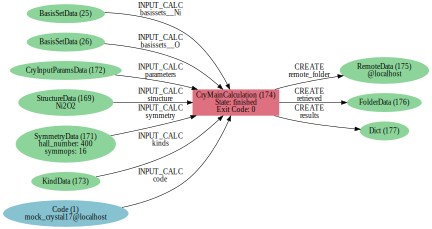

In [56]:
graph = Graph(graph_attr={'size': "6,8!", "rankdir": "LR"})
graph.add_node(calcnode)
graph.add_incoming(calcnode, annotate_links="both")
graph.add_outgoing(calcnode, annotate_links="both")
graph.graphviz

The `retrieved` `FolderData` output node contains the CRYSTAL17 main input and output file.

In [57]:
calcnode.outputs.retrieved.list_object_names()

['_scheduler-stderr.txt', '_scheduler-stdout.txt', 'fort.34', 'main.out']

The `results` `Dict` output node contains key values extracted from the CRYSTAL17 standard output file.

In [58]:
display_json(calcnode.outputs.results.get_dict())

```json
{
  "units": {
    "angle": "degrees",
    "energy": "eV",
    "length": "angstrom",
    "conversion": "CODATA2014"
  },
  "energy": -85124.893667339,
  "errors": [],
  "header": {
    "crystal_version": 17,
    "crystal_subversion": "1.0.1"
  },
  "volume": 36.099581472,
  "warnings": [],
  "calculation": {
    "n_ao": 46,
    "spin": true,
    "type": "unrestricted open shell",
    "n_atoms": 4,
    "n_shells": 14,
    "n_symops": 16,
    "n_core_el": 40,
    "n_electrons": 72,
    "n_kpoints_ibz": 75,
    "n_kpoints_gilat": 75
  },
  "energy_units": "eV",
  "parser_class": "CryMainParser",
  "parser_errors": [],
  "mulliken_spins": [
    3.057,
    -3.057,
    -0.072,
    0.072
  ],
  "parser_version": "0.9.0b5",
  "scf_iterations": 13,
  "number_of_atoms": 4,
  "parser_warnings": [],
  "mulliken_charges": [
    0.398,
    0.397,
    -0.398,
    -0.397
  ],
  "parser_exceptions": [],
  "mulliken_electrons": [
    27.602,
    27.603,
    8.398,
    8.397
  ],
  "mulliken_spin_total": 0.0,
  "number_of_assymetric": 4,
  "execution_time_seconds": 187
}
```

To understand the format of the parsed data,
the raw parser is exposed on the command line as `verdi data crystal17.parse stdout`,
which can be used to parse existing output files.